In [1]:
%matplotlib inline
%config BackendInline.figure_format = "retina"
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import gc
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import cv2
from sklearn import metrics, model_selection
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    BatchNormalization,
    concatenate,
    Input,
)
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Tensorflow version =", tf.__version__)

Tensorflow version = 2.2.0


<IPython.core.display.Javascript object>

In [3]:
def pixel2dbz(img):
    dbz = (img - 0.5) * 70 / 255 - 10
    return dbz


def dbz2r(dbz):
    z = 10 ** (dbz / 10)
    r = (z / 200) ** (1.0 / 1.6)
    return r


def pixel2r(img):
    return dbz2r(pixel2dbz(img))

<IPython.core.display.Javascript object>

# Baseline

## Initialize

In [4]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<IPython.core.display.Javascript object>

In [5]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print("Mixed precision enabled")

Mixed precision enabled


<IPython.core.display.Javascript object>

## Data

In [6]:
NUM_FOLDS = 5
SIZE = 120
BATCH_SIZE = 256
LR = 1e-3
EPOCHS = 10
INPUT_SHAPE = (SIZE, SIZE, 4)

<IPython.core.display.Javascript object>

In [7]:
PATH = Path("../input")
TRAIN_PATH = PATH / "train"
TEST_PATH = PATH / "test"
DAMS = (6071, 6304, 7026, 7629, 7767, 8944, 11107)

<IPython.core.display.Javascript object>

In [8]:
train_paths = list(TRAIN_PATH.glob("*.npy"))
filenames = [path.name for path in train_paths]
len(filenames)

62735

<IPython.core.display.Javascript object>

### Visualize

In [9]:
cmap = plt.cm.get_cmap("RdBu")
cmap = cmap.reversed()

<IPython.core.display.Javascript object>

In [10]:
def visualize(img, cmap=cmap):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i, ax in enumerate(axes[:-1]):
        ax.imshow(img[:, :, i], cmap=cmap)
    axes[-1].imshow(img[:, :, -1], cmap=cmap)
    plt.show()

<IPython.core.display.Javascript object>

35997


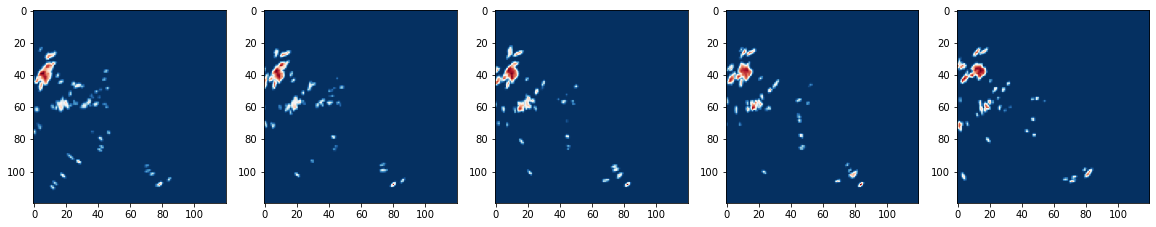

<IPython.core.display.Javascript object>

In [11]:
idx = np.random.randint(len(train_paths))
img = np.load(train_paths[idx])
print(idx)
visualize(img)

In [12]:
img = np.load(train_paths[idx])
img = img[:, :, 0]

<IPython.core.display.Javascript object>

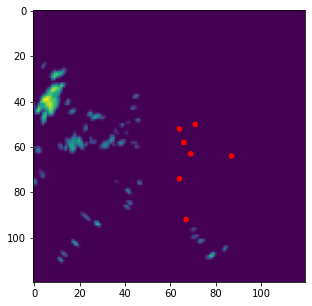

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))

for dam in DAMS:
    x = dam // SIZE
    y = dam % SIZE
    circle = Circle((y, x), 1, color="r")
    ax.add_patch(circle)

ax.imshow(img)
plt.show()

### Make folds

In [15]:
df = pd.DataFrame({"filename": filenames})

<IPython.core.display.Javascript object>

In [16]:
df = train_df.sample(frac=1).reset_index(drop=True)

NameError: name 'train_df' is not defined

<IPython.core.display.Javascript object>

In [ ]:
df["fold"] = -1
kf = model_selection.KFold(n_splits=NUM_FOLDS)
for fold, (train_index, val_index) in enumerate(kf.split(df)):
    df.loc[val_index, "fold"] = fold

In [46]:
df.to_csv("../input/train_folds.csv", index=False)

<IPython.core.display.Javascript object>

## Dataset

In [15]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, shuffle=False, test=False):
        self.filenames = df.filename.values
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.test = test
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.filenames) / self.batch_size)

    def __getitem__(self, index):
        filenames = self.filenames[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        if self.test:
            x = self._data_generation(filenames)
            return x
        else:
            x, y = self._data_generation(filenames)
            return x, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def _data_generation(self, filenames):
        x = np.zeros((len(filenames), SIZE, SIZE, 4))
        y = np.zeros((len(filenames), SIZE, SIZE, 1))
        for i, filename in enumerate(filenames):
            data = np.load((TEST_PATH if self.test else TRAIN_PATH) / filename)
            image = data[:, :, :4]
            #             image = image / 255
            #             image = image.astype(np.float32)
            x[i] = image

            if not self.test:
                target = data[:, :, -1].reshape(SIZE, SIZE, 1)
                target = np.where(target < 0, 0, target)
                #                 target = target / 255
                #                 target = target.astype(np.float32)
                y[i] = target

        if self.test:
            return x
        else:
            return x, y

<IPython.core.display.Javascript object>

In [16]:
# df = pd.read_csv(PATH / "train_folds.csv")
# gen = DataGenerator(df, batch_size=BATCH_SIZE, shuffle=True)
# for batch in gen:
#     x, y = batch
#     inp = x[10]
#     targ = y[10]
#     img = np.concatenate([inp, targ], axis=-1)
#     visualize(img, cmap=cmap)
#     break

<IPython.core.display.Javascript object>

## Model

In [17]:
df = pd.read_csv(PATH / "train_folds.csv")

<IPython.core.display.Javascript object>

In [18]:
def get_baseline(input_shape):
    inp = Input(input_shape)

    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inp)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(2)(bn1)

    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(2)(bn2)

    convm = Conv2D(256, 3, activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(128, 3, strides=2, padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(128, 3, activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(64, 3, strides=2, padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(128, 3, activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    out = Conv2D(1, 1, padding="same", activation="relu")(uconv1)

    model = Model(inp, out)

    #     decay_steps = EPOCHS * math.ceil(len(df) / BATCH_SIZE)
    #     scheduler = tf.keras.experimental.CosineDecay(
    #         initial_learning_rate=LR, decay_steps=decay_steps
    #     )
    #     optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss = tf.keras.losses.LogCosh()

    model.compile(loss=loss, optimizer=optimizer, metrics=["mse"])

    return model

<IPython.core.display.Javascript object>

## Custom callback

In [19]:
class CustomCallback(tf.keras.callbacks.Callback):
    """Early stopping based on CSI + MAE metrics"""

    def __init__(self, val_x, val_y, patience=5):
        super(CustomCallback, self).__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.counter = 0
        self.best_score = np.inf
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_x)
        y_pred = preds.reshape(len(preds), -1)
        y_true = self.val_y.reshape(len(self.val_y), -1)
        y_pred = y_pred[:, DAMS]
        y_true = y_true[:, DAMS]
        score = metrics.mean_absolute_error(y_true, y_pred)
        print("\nScore:", score)

        if np.less(score, self.best_score):
            self.best_score = score
            self.patience = 0
            self.best_weights = self.model.get_weights()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("\nRestoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch:05d}: early stopping")

<IPython.core.display.Javascript object>

## Train

In [ ]:
oof = []
targs = []

for fold in range(NUM_FOLDS):
    print("-" * 25)
    print(f"Training fold {fold}")

    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    train_gen = DataGenerator(train_df, batch_size=BATCH_SIZE, shuffle=True)

    # GET VALIDATION DATA
    val_gen = DataGenerator(val_df, batch_size=BATCH_SIZE * 4, shuffle=False)
    val_x, val_y = [], []
    for batch in val_gen:
        x, y = batch
        val_x.append(x)
        val_y.append(y)
    val_x = np.concatenate(val_x)
    val_y = np.concatenate(val_y)

    # MODEL
    with strategy.scope():
        model = get_baseline(INPUT_SHAPE)

    # CALLBACKS
#     early_stopping = tf.keras.callbacks.EarlyStopping(
#         monitor="mse", patience=3, mode="min", restore_best_weights=True
#     )
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
    custom_callback = CustomCallback(val_x, val_y, patience=5)
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        verbose=1,
        workers=3,
        callbacks=[custom_callback],
        validation_data=(val_x, val_y),
    )
    model.save_weights(f"baseline_fold{fold}.h5")

    oo = model.predict(val_x)
    oof.append(oo)
    targs.append(val_y)

    np.save(f"oof-fold{fold}", oo)
    np.save(f"val_y-fold{fold}", val_y)

    del model, train_df, val_df, train_gen, val_gen, val_x, val_y, oo, history, custom_callback
    K.clear_session()
    gc.collect()
    
oof = np.concatenate(oof)
targs = np.concatenate(targs)

-------------------------
Training fold 0
Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 10.1159 - mse: 878.6193
Score: 7.663203703866012
197/197 [==============================] - 444s 2s/step - loss: 10.1159 - mse: 878.6193 - val_loss: 5.4786 - val_mse: 300.4308
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 5.7703 - mse: 299.9737
Score: 6.976466387893564
197/197 [==============================] - 98s 499ms/step - loss: 5.7703 - mse: 299.9737 - val_loss: 4.9947 - val_mse: 254.1404
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 4.4636 - mse: 202.7152

In [21]:
oof = []
targs = []

for fold in range(NUM_FOLDS):
    oo = np.load(f"oof-fold{fold}.npy")
    oof.append(oo)
    targ = np.load(f"val_y-fold{fold}.npy")
    targs.append(targ)

oof = np.concatenate(oof)
targs = np.concatenate(targs)
oof.shape, targs.shape

((62735, 120, 120, 1), (62735, 120, 120, 1))

<IPython.core.display.Javascript object>

In [22]:
y_true = targs.reshape(len(df), -1)
y_pred = oof.reshape(len(df), -1)
y_true = y_true[:, DAMS]
y_pred = y_pred[:, DAMS]
mae = metrics.mean_absolute_error(y_true, y_pred)
print(mae)

7.452542545695364


<IPython.core.display.Javascript object>

## Inference

In [23]:
def get_test():
    imgs = []
    test_paths = sorted(TEST_PATH.glob("*.npy"))
    for i, test_path in enumerate(test_paths):
        data = np.load(test_path)
        img = data[:, :, :4]
        img = np.where(img < 0, 0, img)
        #         img = img / 255
        #         img = img.astype(np.float32)
        imgs.append(img)

    imgs = np.stack(imgs)

    return imgs

<IPython.core.display.Javascript object>

In [24]:
test_imgs = get_test()
preds = np.zeros((len(test_imgs), SIZE * SIZE))

for fold in range(NUM_FOLDS):
    with strategy.scope():
        model = get_baseline(INPUT_SHAPE)
    model.load_weights(f"baseline_fold{fold}.h5")

    pred = model.predict(test_imgs, verbose=1)
    pred = pred.reshape(len(pred), -1)
    preds += pred

preds /= NUM_FOLDS
preds = np.round(preds)
preds = np.clip(preds, 0, 255)
preds = preds.astype(np.uint8)

84/84 [==============================] - 1s 16ms/step


<IPython.core.display.Javascript object>

In [25]:
np.save("preds", preds)

<IPython.core.display.Javascript object>

In [26]:
del test_imgs, preds, model
gc.collect()

4590

<IPython.core.display.Javascript object>

In [27]:
preds = np.load("preds.npy")

<IPython.core.display.Javascript object>

In [28]:
file_names = [path.name for path in sorted(TEST_PATH.glob("*.npy"))]

<IPython.core.display.Javascript object>

In [29]:
subm = pd.DataFrame({"file_name": file_names})
for i in tqdm(range(SIZE * SIZE)):
    col = str(i)
    subm[col] = preds[:, i]

<IPython.core.display.Javascript object>

In [31]:
subm.to_csv("baseline2.csv", index=False)

<IPython.core.display.Javascript object>

In [30]:
subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Columns: 14401 entries, file_name to 14399
dtypes: object(1), uint8(14400)
memory usage: 36.7+ MB


<IPython.core.display.Javascript object>

In [32]:
subm.head()

,file_name,0,1,2,3,4,5,6,7,8,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,test_00000.npy,2,3,2,2,2,2,2,2,2,...,3,4,3,4,3,4,3,4,4,2
1,test_00001.npy,2,3,2,2,2,2,2,2,2,...,3,4,3,4,3,4,3,4,4,2
2,test_00002.npy,2,3,2,2,2,2,2,2,2,...,3,4,3,4,3,4,3,4,4,2
3,test_00003.npy,2,3,2,2,2,2,2,2,2,...,3,4,3,4,3,4,3,4,4,2
4,test_00004.npy,2,3,2,2,2,2,2,2,2,...,3,4,3,4,3,4,3,4,4,2


<IPython.core.display.Javascript object>